## Transform ROXSI SSA pressure measurements to sea-surface elevation

In [66]:
# Imports
import os
import sys
sys.path.append("/home/malila/Github/pyROXSI/roxsi_pyfuns/")
import glob
import numpy as np
import pandas as pd
from datetime import datetime as DT
from scipy.io import loadmat
from scipy.signal import detrend
import matplotlib.pyplot as plt
import ipympl
# Interactive plots
%matplotlib widget 
# from roxsi_pyfuns import transfer_functions as tf
import transfer_functions as tf
import wave_spectra as ws


In [67]:
# Define paths and load data
datestr = '20220630'
# SSA mooring ID's for DuetDT: [L2vp, L4vp, C15p, C2vp, C3vp, C4vp]
mooring_id = 'C15p'
sensor_id = 'duetDT'

# Data directory
if sensor_id == 'duetDT':
    datadir = '/home/malila/ROXSI/Asilomar2022/SmallScaleArray/RBRDuetDT/Level1/mat'
elif sensor_id == 'soloD':
    datadir = '/home/malila/ROXSI/Asilomar2022/SmallScaleArray/RBRSoloD/Level1/mat'


# Load ROXSI pressure sensor time series
fn_mat = glob.glob(os.path.join(datadir, 'roxsi_{}_L1_{}_*_{}.mat'.format(
    sensor_id, mooring_id, datestr)))[0]
print('Loading pressure sensor mat file {}'.format(os.path.basename(fn_mat)))
mat = loadmat(fn_mat)
# Read pressure time series and timestamps
pt = np.array(mat['DUETDT']['Pwater'].item()).squeeze()
time_mat = np.array(mat['DUETDT']['time_dnum'].item()).squeeze()
time_ind = pd.to_datetime(time_mat-719529,unit='d') # Convert timestamps
# Read sampling frequency and sensor height above seabed
fs = int(mat['DUETDT']['sample_freq'].item()[0].split(' ')[0])
zp = mat['DUETDT']['Zbed'].item().squeeze().item()
# Make pandas DataFrame
dfp = pd.DataFrame(data={'eta_hyd':pt}, index=time_ind)

Loading pressure sensor mat file roxsi_duetDT_L1_C15p_210356_20220630.mat


## Apply linear transfer function

N = 20480
ss=0, se=4096
ss=2048, se=6144
ss=4096, se=8192
ss=6144, se=10240
ss=8192, se=12288
ss=10240, se=14336
ss=12288, se=16384
ss=14336, se=18432
ss=16384, se=19200


/home/malila/Github/pyROXSI/roxsi_pyfuns/transfer_functions.py:156: RuntimeWarning: overflow encountered in cosh
  Kp = np.cosh(ks*self.zp) / np.cosh(ks*dseg)


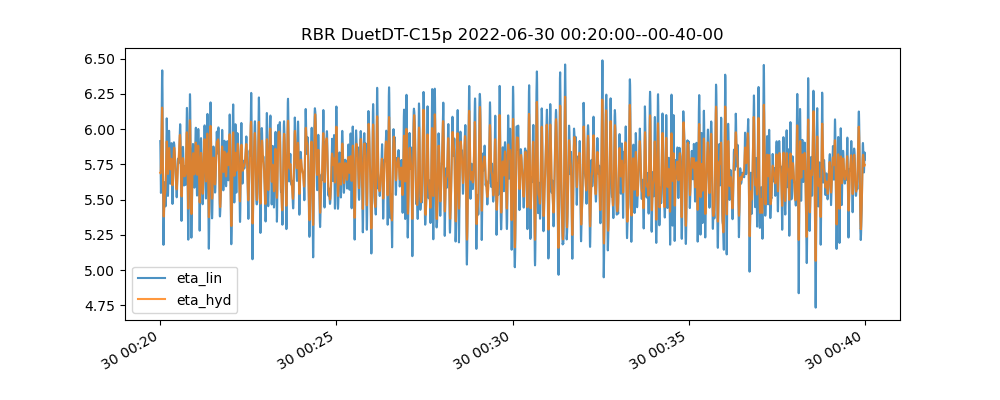

In [68]:
# Initialize class
if sensor_id == 'soloD':
    trf = tf.TRF(fs=fs, zp=zp, type='RBR SoloD')
elif sensor_id == 'duetDT':
    trf = tf.TRF(fs=fs, zp=zp, type='RBR DuetDT')
# Transform pressure -> eta for 20-min chunks
M = 512*8 # Window length (no. of samples)
fmin = 0.05 # Min. cutoff frequency
fmax = 1.0 # Max. cutoff frequency
i0 = 19200 * 1 # Start index of test segment
i1 = 19200 * 2 # End index of test segment
dft = dfp.iloc[i0:i1].copy() # Test time series (20min)
eta = trf.p2eta_lin(dft['eta_hyd'], M=M, fmin=fmin, fmax=fmax)
dft['eta_lin'] = eta

# Plot pressure and sea-surface elevation time series
fig, ax = plt.subplots(figsize=(10,4))
dft[['eta_lin', 'eta_hyd']].plot(ax=ax, alpha=0.8)
ax.set_title('{}-{} {}--{}'.format(trf.type, mooring_id, 
    pd.Timestamp(dft.index[0]).round('s'), 
    DT.strftime(dft.index[-1].round('s'), format='%H-%M-%S')))
plt.show()
# plt.close()


## Estimate spectra

bandwidth =  0.019559902200488997


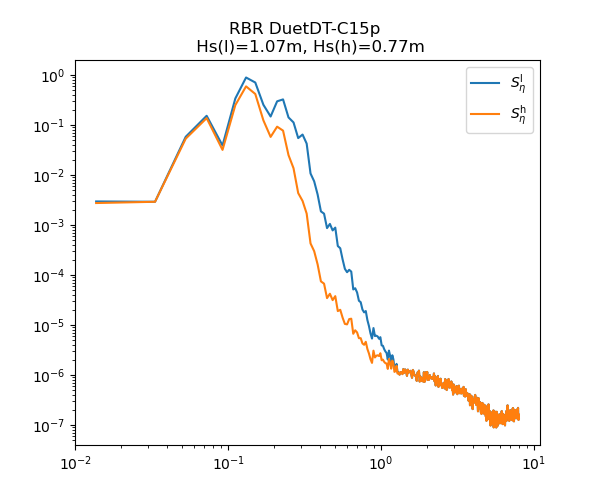

In [69]:
# Detrend data
eta_dt = detrend(dft['eta_lin'].values)
p_dt = detrend(dft['eta_hyd'].values)

# Estimate spectrum of linear sea-surface reconstruction
# and hydrostatic pressure
Ee, freqs = ws.spec_uvz(eta_dt, fs=16, fmerge=5, fmin=0.01)
Ep, freqs = ws.spec_uvz(p_dt, fs=16, fmerge=5, fmin=0.01)

# Compute integrated parameters
fs = 16
nfreqs = len(freqs)
nyquist = 0.5 * fs # Max spectral frequency
bandwidth = nyquist / nfreqs
print('bandwidth = ', bandwidth)
Hse = 4 * np.sqrt(np.sum(Ee) * bandwidth)
Hsp = 4 * np.sqrt(np.sum(Ep) * bandwidth)


# Plot the spectra
fig, ax = plt.subplots(figsize=(6,5))
ax.loglog(freqs, Ee, label=r'$S_{\eta}^\mathrm{l}$')
ax.loglog(freqs, Ep, label=r'$S_{\eta}^\mathrm{h}$')
ax.legend()
ax.set_title('{}-{} \n Hs(l)={:.2f}m, Hs(h)={:.2f}m'.format(
    trf.type, mooring_id, Hse, Hsp))
plt.show()
# plt.close()


In [63]:
from datetime import datetime as DT
DT.strftime(dft.index[-1].round('s'), format='%H-%M-%S')

'00-40-00'